# HOAX

## Predictive model to check reports of environmental accidents

### Data processing

Import libraries:

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.svm import SVC

from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

2023-02-03 14:25:27.851485: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-03 14:25:30.539969: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-03 14:25:30.539998: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-03 14:25:42.177436: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Auxiliary functions:

In [2]:
def is_str(data):
    return 1 if pd.notna(data) and data != "Não há descrição" else 0

def first_str(data):
    return data.split(';')[0]

def count_str(data):
    return len(data.split(';')) if pd.notna(data) else 0

Getting data from the database:

 - Siema: communications of environmental accidents (managed by IBAMA)
 - It is proposed the creation of a system for validating reports of environmental accidents in order to avoid bad use of public resources

In [3]:
cols = [
    'institiuicoes_atuando_local', 'iniciados_outras_providencias', 'origem',
    'plano_emergencia_acionado', 'informacao_responsavel', 'ocorrencia_oleo',
    'informacao_geografica', 'tipos_fontes_informacoes', 'des_ocorrencia',
    'uf', 'tipos_danos_identificados', 'periodo_ocorrencia', 'validado'
]

notifications = pd.read_csv("data/comunicacidente.csv", low_memory=False, usecols=cols)[cols]

notifications.head()

,institiuicoes_atuando_local,iniciados_outras_providencias,origem,plano_emergencia_acionado,informacao_responsavel,ocorrencia_oleo,informacao_geografica,tipos_fontes_informacoes,des_ocorrencia,uf,tipos_danos_identificados,periodo_ocorrencia,validado
0,Corpo de Bombeiros;Polícia Rodoviária,N,Rodovia,N,N,N,S,Mídia,Tombamento de caminhão carregado de biocombust...,AL,Óbitos/feridos,M,S
1,Corpo de Bombeiros,N,Armazenamento/depósito,N,N,N,S,Mídia,Explosão em depósito de gás.,ES,Outro(s),M,S
2,Outra(s),N,Outro(s),N,N,N,S,Mídia,Vazamento de esgoto em grande quantidade causa...,MS,Fauna;Flora;População afetada/evacuada;Rio/cór...,M,S
3,Corpo de Bombeiros;Defesa Civil,N,Rodovia,N,N,N,S,Mídia,Tombamento de caminhão carregado de combustíve...,DF,Solo,M,S
4,Outra(s),N,Outro(s),N,N,N,S,Mídia,300 Kg de produtos poluidores encontrados ás m...,RS,Rio/córrego;Solo,M,S


In [4]:
notifications.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13127 entries, 0 to 13126
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   institiuicoes_atuando_local    11548 non-null  object
 1   iniciados_outras_providencias  13127 non-null  object
 2   origem                         12980 non-null  object
 3   plano_emergencia_acionado      13127 non-null  object
 4   informacao_responsavel         13127 non-null  object
 5   ocorrencia_oleo                13127 non-null  object
 6   informacao_geografica          6861 non-null   object
 7   tipos_fontes_informacoes       12812 non-null  object
 8   des_ocorrencia                 5775 non-null   object
 9   uf                             12340 non-null  object
 10  tipos_danos_identificados      12211 non-null  object
 11  periodo_ocorrencia             12418 non-null  object
 12  validado                       13127 non-null  object
dtypes

An initial look at the dataframe allows observing the lack of uniformity in the treatment of boolean data:

 - `plano_emergencia_acionado`, `iniciados_outras_providencias`, `ocorrencia_oleo` and `validado`: [N, S]
 - `informacao_geografica`: [nan, S]
 - `informacao_responsavel`: [N, T]

In [5]:
# Column plano_emergencia_acionado

notifications['plano_emergencia_acionado'] = notifications['plano_emergencia_acionado'].map({'N' : 0,
                                                                                             'S' : 1})

notifications['plano_emergencia_acionado']

0        0
1        0
2        0
3        0
4        0
        ..
13122    0
13123    0
13124    0
13125    0
13126    0
Name: plano_emergencia_acionado, Length: 13127, dtype: int64

In [6]:
# Column iniciados_outras_providencias

notifications['iniciados_outras_providencias'] = notifications['iniciados_outras_providencias'].map({'N' : 0,
                                                                                                     'S' : 1})

notifications['iniciados_outras_providencias']

0        0
1        0
2        0
3        0
4        0
        ..
13122    0
13123    1
13124    0
13125    1
13126    1
Name: iniciados_outras_providencias, Length: 13127, dtype: int64

In [7]:
# Column ocorrencia_oleo

notifications['ocorrencia_oleo'] = notifications['ocorrencia_oleo'].map({'N' : 0,
                                                                         'S' : 1})

notifications['ocorrencia_oleo']

0        0
1        0
2        0
3        0
4        0
        ..
13122    1
13123    0
13124    0
13125    0
13126    0
Name: ocorrencia_oleo, Length: 13127, dtype: int64

In [8]:
# Column informacao_geografica

notifications['informacao_geografica'] = notifications['informacao_geografica'].map({np.nan : 0,
                                                                                     'S' : 1})

notifications['informacao_geografica']

0        1
1        1
2        1
3        1
4        1
        ..
13122    0
13123    0
13124    0
13125    0
13126    0
Name: informacao_geografica, Length: 13127, dtype: int64

In [9]:
# Column informacao_responsavel

notifications['informacao_responsavel'] = notifications['informacao_responsavel'].map({'N' : 0,
                                                                                       'T' : 1})

notifications['informacao_responsavel']

0        0
1        0
2        0
3        0
4        0
        ..
13122    1
13123    1
13124    0
13125    1
13126    1
Name: informacao_responsavel, Length: 13127, dtype: int64

In [10]:
# Column validado

notifications['validado'] = notifications['validado'].map({'N' : 0,
                                                           'S' : 1})

notifications['validado']

0        1
1        1
2        1
3        1
4        1
        ..
13122    1
13123    1
13124    0
13125    1
13126    1
Name: validado, Length: 13127, dtype: int64

In [11]:
# Column periodo_ocorrencia

notifications.dropna(subset=['periodo_ocorrencia'], inplace=True)  # droping empty values

le_period = LabelEncoder()  # encode target labels
le_period.fit(notifications['periodo_ocorrencia'])

notifications['periodo_ocorrencia'] = le_period.transform(notifications['periodo_ocorrencia'])  

notifications['periodo_ocorrencia'].value_counts()  # S -> Sembrol (00:00 to 05:59)

0    8178
3    2119
1    1094
2    1027
Name: periodo_ocorrencia, dtype: int64

In [12]:
# To decode use le_period.inverse_transform([])

pd.DataFrame(le_period.inverse_transform(notifications['periodo_ocorrencia'])).value_counts()

M    8178
V    2119
N    1094
S    1027
dtype: int64

In [13]:
# Column uf

notifications.dropna(subset=['uf'], inplace=True)  # droping empty values

le_uf = LabelEncoder()  # encode target labels
le_uf.fit(notifications['uf'])

notifications['uf'] = le_uf.transform(notifications['uf'])

notifications['uf'].value_counts()

10    3217
25    2241
18    1936
17     606
22     484
4      463
23     402
7      385
11     212
24     209
8      182
5      171
6      137
12     136
9      133
19     132
2      125
1      120
13     103
15      83
26      58
20      49
14      46
16      36
3       12
21       8
0        5
Name: uf, dtype: int64

In [14]:
# Column des_ocorrencia (we get the information if it has a description or not)

notifications['des_ocorrencia'] = notifications['des_ocorrencia'].apply(is_str)

notifications['des_ocorrencia'].value_counts()

0    5918
1    5773
Name: des_ocorrencia, dtype: int64

In [15]:
# Column origem

notifications['origem'].unique()

array(['Rodovia', 'Armazenamento/depósito', 'Outro(s)', 'Indústria',
       'Plataforma', 'Embarcação', 'Ferrovia',
       'Terminal/portos/ancoradouros/etc', 'Duto', 'Posto de combustível',
       'Barragem', 'Refinaria', nan, 'Ferrovia;Rodovia',
       'Embarcação;Terminal/portos/ancoradouros/etc',
       'Embarcação;Plataforma', 'Ferrovia;Outro(s)', 'Duto;Outro(s)',
       'Posto de combustível;Rodovia',
       'Armazenamento/depósito;Terminal/portos/ancoradouros/etc',
       'Embarcação;Outro(s)', 'Outro(s);Plataforma',
       'Armazenamento/depósito;Barragem', 'Indústria;Outro(s)',
       'Armazenamento/depósito;Rodovia',
       'Armazenamento/depósito;Outro(s)',
       'Barragem;Terminal/portos/ancoradouros/etc', 'Indústria;Rodovia',
       'Armazenamento/depósito;Indústria', 'Outro(s);Rodovia',
       'Outro(s);Terminal/portos/ancoradouros/etc',
       'Posto de combustível;Terminal/portos/ancoradouros/etc',
       'Duto;Plataforma', 'Plataforma;Terminal/portos/ancoradouros/etc'

In [16]:
# Considering the assumption that there is a hierarchical order of classification

notifications.dropna(subset=['origem'], inplace=True)  # droping empty values

notifications['origem'] = notifications['origem'].apply(first_str)  # getting first origin description

le_origin = LabelEncoder()  # encode target labels
le_origin.fit(notifications['origem'])

notifications['origem'] = le_origin.transform(notifications['origem'])

notifications['origem'].value_counts()

10    4104
6     1992
7     1380
4     1114
5      811
3      790
2      613
11     279
0      215
1      142
8      137
9       39
Name: origem, dtype: int64

In [17]:
# Column institiuicoes_atuando_local

notifications['institiuicoes_atuando_local'].unique()

array(['Corpo de Bombeiros;Polícia Rodoviária', 'Corpo de Bombeiros',
       'Outra(s)', 'Corpo de Bombeiros;Defesa Civil', 'IBAMA;Outra(s)',
       'Corpo de Bombeiros;Defesa Civil;Outra(s);Polícia Civil',
       'Outra(s);Polícia Rodoviária',
       'Corpo de Bombeiros;Outra(s);Polícia Militar',
       'Corpo de Bombeiros;Outra(s)', 'IBAMA',
       'Defesa Civil;IBAMA;Outra(s)',
       'Corpo de Bombeiros;Defesa Civil;Outra(s)', 'Polícia Rodoviária',
       'Corpo de Bombeiros;IBAMA;Polícia Rodoviária',
       'Corpo de Bombeiros;IBAMA', 'Polícia Civil;Polícia Militar',
       'Polícia Militar', 'Outra(s);Polícia Militar',
       'Corpo de Bombeiros;Outra(s);Polícia Rodoviária',
       'Corpo de Bombeiros;Outra(s);Polícia Militar;Polícia Rodoviária',
       'Outra(s);Polícia Civil',
       'Corpo de Bombeiros;Defesa Civil;Polícia Rodoviária',
       'Corpo de Bombeiros;Polícia Civil',
       'Corpo de Bombeiros;Polícia Militar',
       'Corpo de Bombeiros;Defesa Civil;IBAMA;Outra(s);

In [18]:
# We obtain relevant information on how many institutions are operating in the area

notifications['institiuicoes_atuando_local'] = notifications['institiuicoes_atuando_local'].apply(count_str)

notifications.rename(columns={'institiuicoes_atuando_local':
                              'quant_instituicoes_atuando_local'},
                     inplace=True)

notifications['quant_instituicoes_atuando_local']

0        2
1        1
2        1
3        2
4        1
        ..
13119    0
13123    1
13124    0
13125    1
13126    1
Name: quant_instituicoes_atuando_local, Length: 11616, dtype: int64

In [19]:
# Column tipos_fontes_informacoes (same strategy as column 'institiuicoes_atuando_local')

notifications['tipos_fontes_informacoes'] = notifications['tipos_fontes_informacoes'].apply(count_str)

notifications.rename(columns={'tipos_fontes_informacoes':
                              'quant_fontes_informacoes'},
                     inplace=True)

notifications['quant_fontes_informacoes']

0        1
1        1
2        1
3        1
4        1
        ..
13119    1
13123    1
13124    1
13125    1
13126    0
Name: quant_fontes_informacoes, Length: 11616, dtype: int64

In [20]:
# Column tipos_danos_identificados (same strategy as column 'institiuicoes_atuando_local')

notifications['tipos_danos_identificados'] = notifications['tipos_danos_identificados'].apply(count_str)

notifications.rename(columns={'tipos_danos_identificados':
                              'quant_tipos_danos_identificados'},
                     inplace=True)

notifications['quant_tipos_danos_identificados']

0        1
1        1
2        4
3        1
4        2
        ..
13119    2
13123    2
13124    1
13125    1
13126    3
Name: quant_tipos_danos_identificados, Length: 11616, dtype: int64

### Exploratory analysis

Database obtained after pre-processing:

In [21]:
notifications.head()

,quant_instituicoes_atuando_local,iniciados_outras_providencias,origem,plano_emergencia_acionado,informacao_responsavel,ocorrencia_oleo,informacao_geografica,quant_fontes_informacoes,des_ocorrencia,uf,quant_tipos_danos_identificados,periodo_ocorrencia,validado
0,2,0,10,0,0,0,1,1,1,1,1,0,1
1,1,0,0,0,0,0,1,1,1,7,1,0,1
2,1,0,6,0,0,0,1,1,1,11,4,0,1
3,2,0,10,0,0,0,1,1,1,6,1,0,1
4,1,0,6,0,0,0,1,1,1,22,2,0,1


Checking the distribution of validated occurrences:

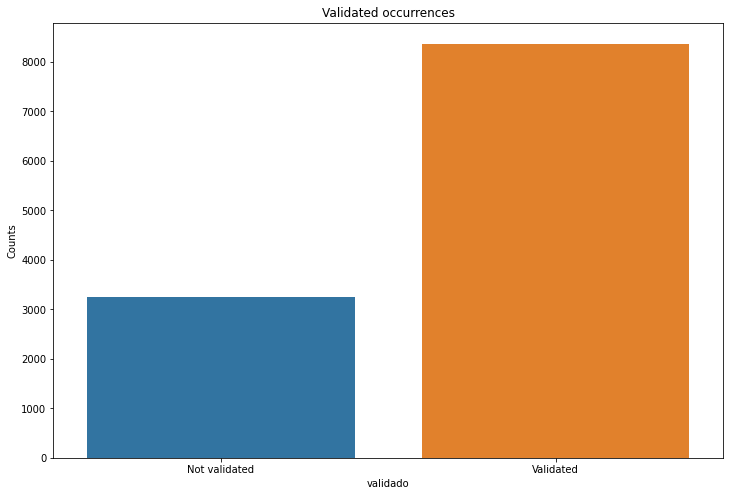

In [22]:
plt.figure(figsize=(12, 8))

sns.countplot(x=notifications.validado)

plt.title("Validated occurrences")
plt.xticks(ticks=[0, 1], labels=["Not validated", "Validated"])
plt.ylabel("Counts")

plt.show()

Checking attribute distribution:

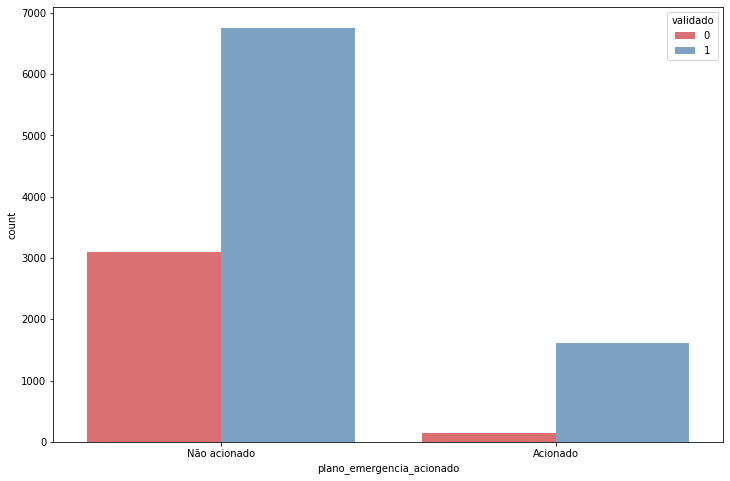

In [23]:
plt.figure(figsize=(12, 8))

sns.countplot(data=notifications, x="plano_emergencia_acionado", hue="validado",
              palette='Set1', alpha =.7)
plt.xticks([0, 1], ["Não acionado", "Acionado"])

plt.show()

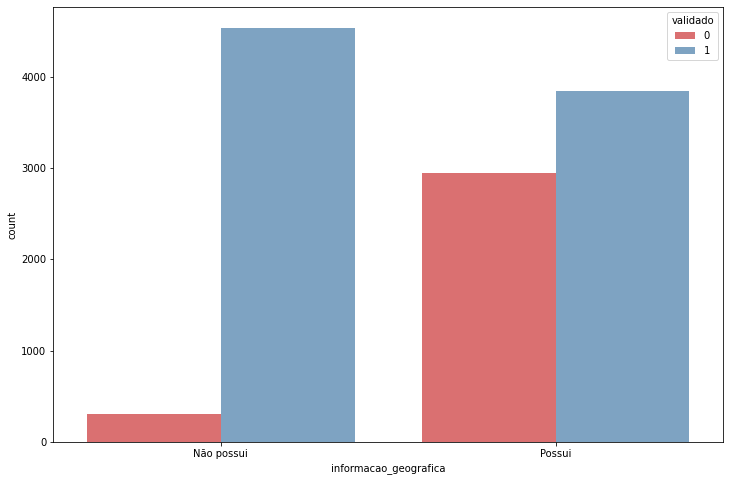

In [24]:
plt.figure(figsize=(12, 8))

sns.countplot(data=notifications, x="informacao_geografica", hue="validado",
              palette='Set1', alpha =.7)
plt.xticks([0, 1], ["Não possui", "Possui"])

plt.show()

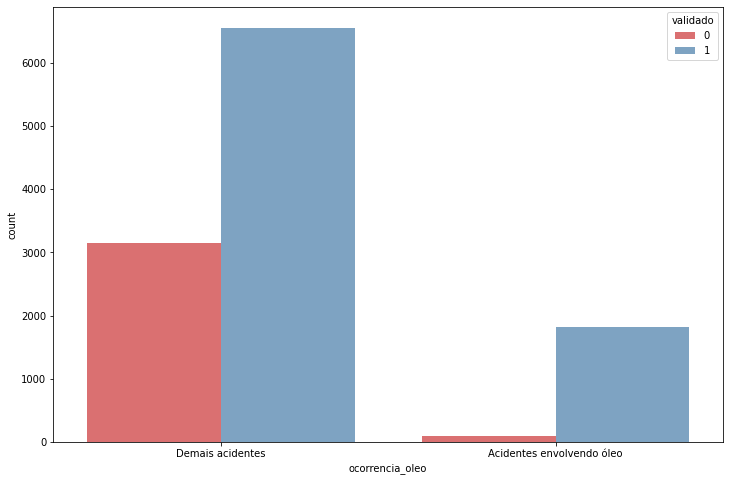

In [25]:
plt.figure(figsize=(12, 8))

sns.countplot(data=notifications, x="ocorrencia_oleo", hue="validado",
              palette='Set1', alpha =.7)
plt.xticks([0, 1], ["Demais acidentes", "Acidentes envolvendo óleo"])

plt.show()

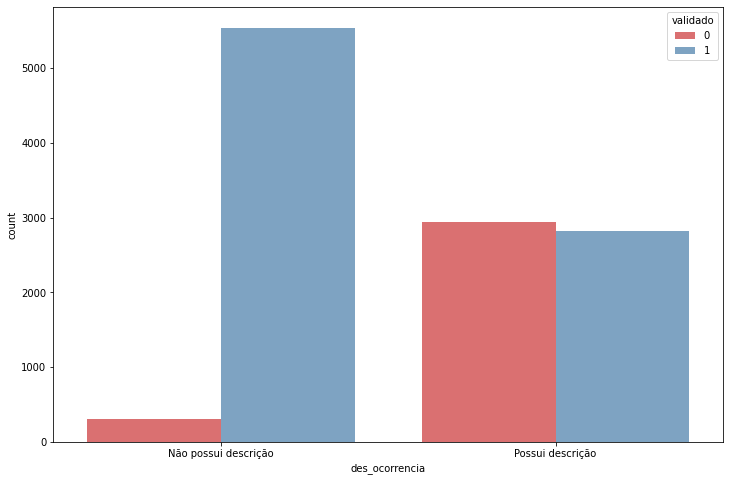

In [26]:
plt.figure(figsize=(12, 8))

sns.countplot(data=notifications, x="des_ocorrencia", hue="validado",
              palette='Set1', alpha =.7)
plt.xticks([0, 1], ["Não possui descrição", "Possui descrição"])

plt.show()

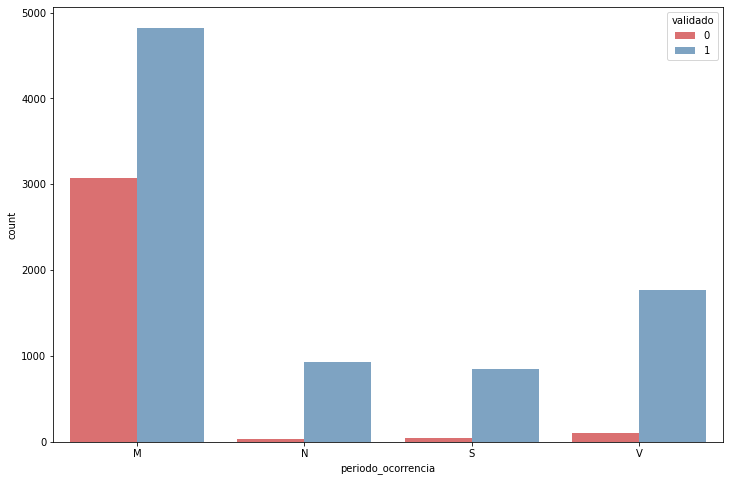

In [27]:
plt.figure(figsize=(12, 8))

sns.countplot(data=notifications, x="periodo_ocorrencia", hue="validado",
              palette='Set1', alpha =.7)
plt.xticks(np.arange(len(le_period.classes_)), le_period.classes_)

plt.show()

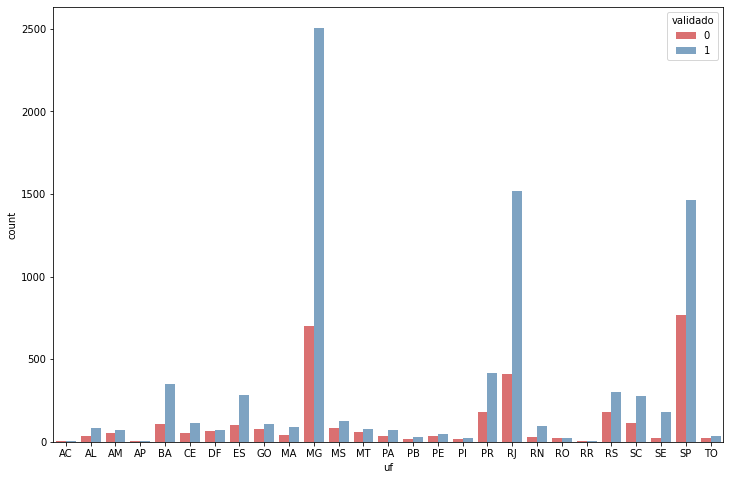

In [28]:
plt.figure(figsize=(12, 8))

sns.countplot(data=notifications, x="uf", hue="validado",
              palette='Set1', alpha =.7)
plt.xticks(np.arange(len(le_uf.classes_)), le_uf.classes_)

plt.show()

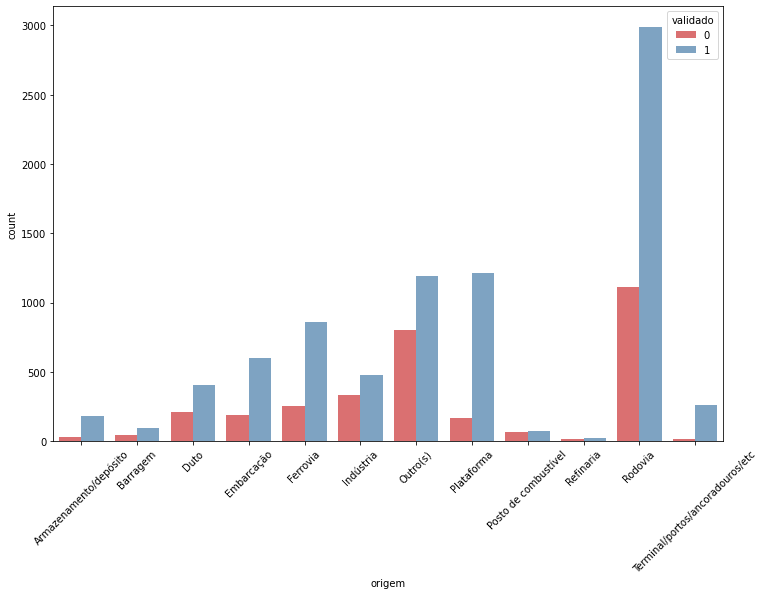

In [29]:
plt.figure(figsize=(12, 8))

sns.countplot(data=notifications, x="origem", hue="validado",
              palette='Set1', alpha =.7)
plt.xticks(np.arange(len(le_origin.classes_)), le_origin.classes_, rotation=45)

plt.show()

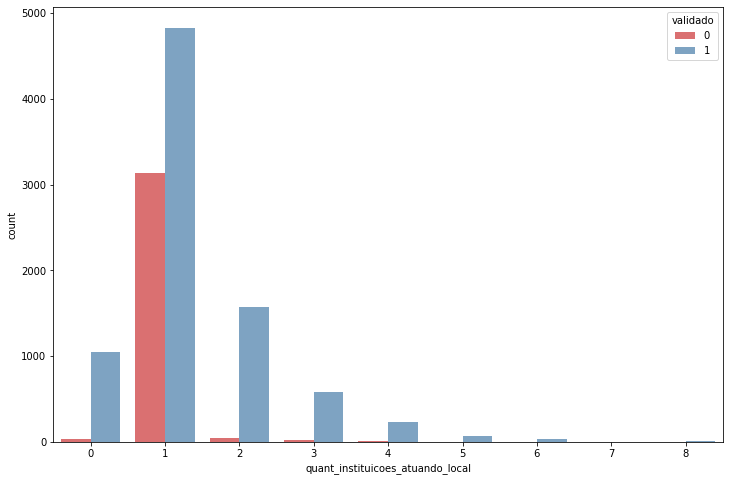

In [30]:
plt.figure(figsize=(12, 8))

sns.countplot(data=notifications, x="quant_instituicoes_atuando_local", hue="validado",
              palette='Set1', alpha =.7)

plt.show()

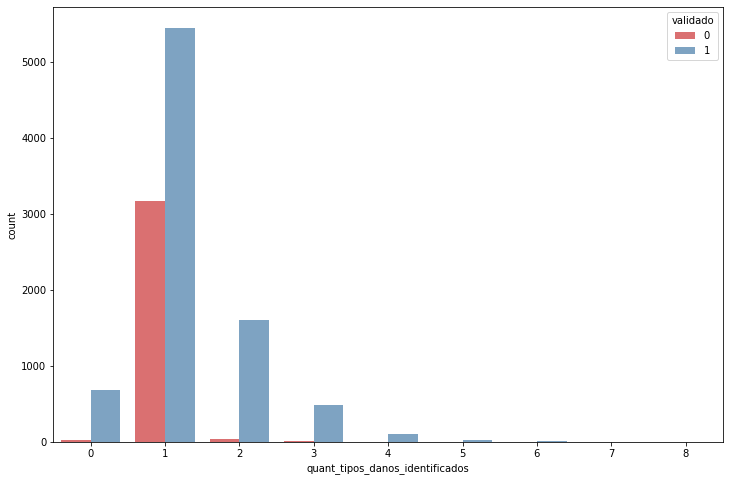

In [31]:
plt.figure(figsize=(12, 8))

sns.countplot(data=notifications, x="quant_tipos_danos_identificados", hue="validado",
              palette='Set1', alpha =.7)

plt.show()

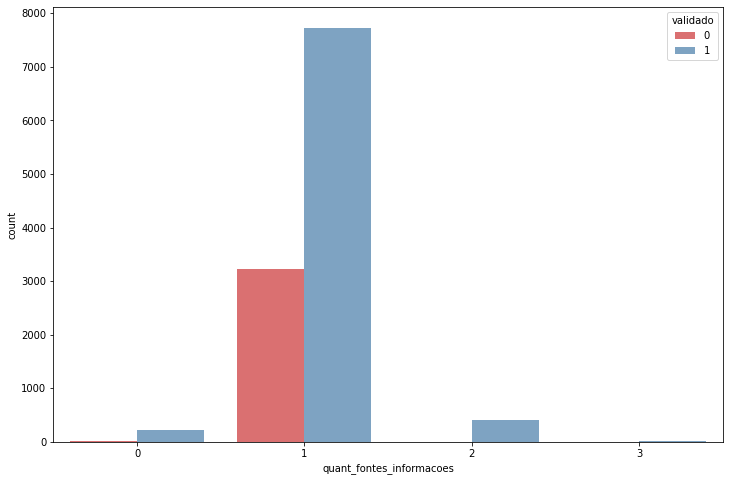

In [32]:
plt.figure(figsize=(12, 8))

sns.countplot(data=notifications, x="quant_fontes_informacoes", hue="validado",
              palette='Set1', alpha =.7)

plt.show()

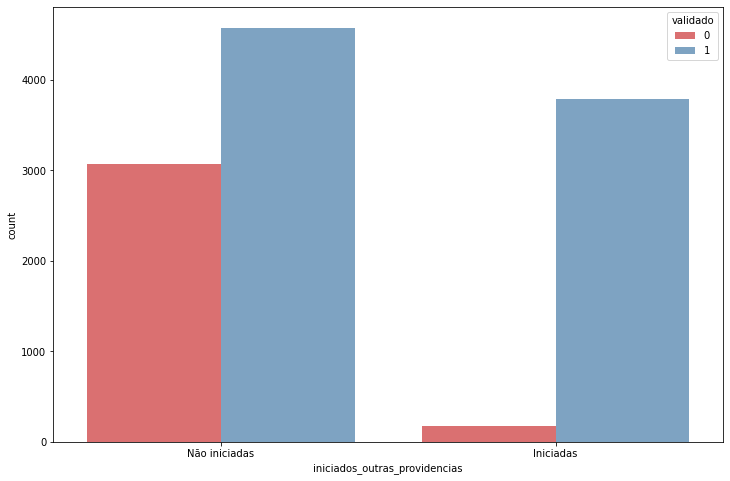

In [33]:
plt.figure(figsize=(12, 8))

sns.countplot(data=notifications, x="iniciados_outras_providencias", hue="validado",
              palette='Set1', alpha =.7)
plt.xticks([0, 1], ["Não iniciadas", "Iniciadas"])

plt.show()

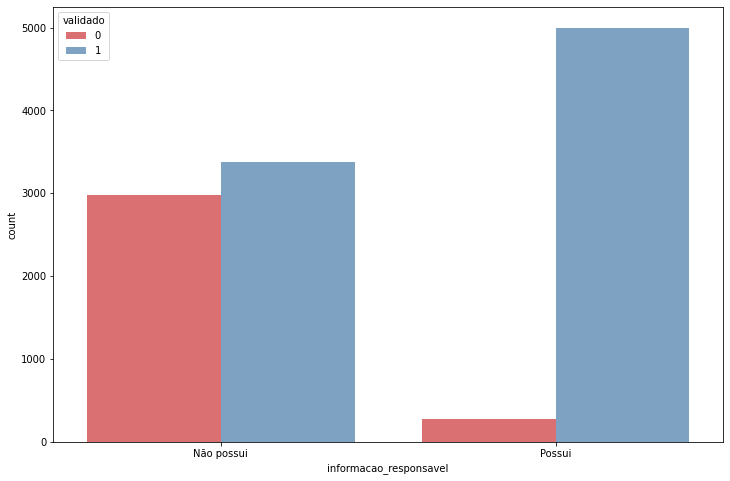

In [34]:
plt.figure(figsize=(12, 8))

sns.countplot(data=notifications, x="informacao_responsavel", hue="validado",
              palette='Set1', alpha =.7)
plt.xticks([0, 1], ["Não possui", "Possui"])

plt.show()

Checking the correlation matrix:

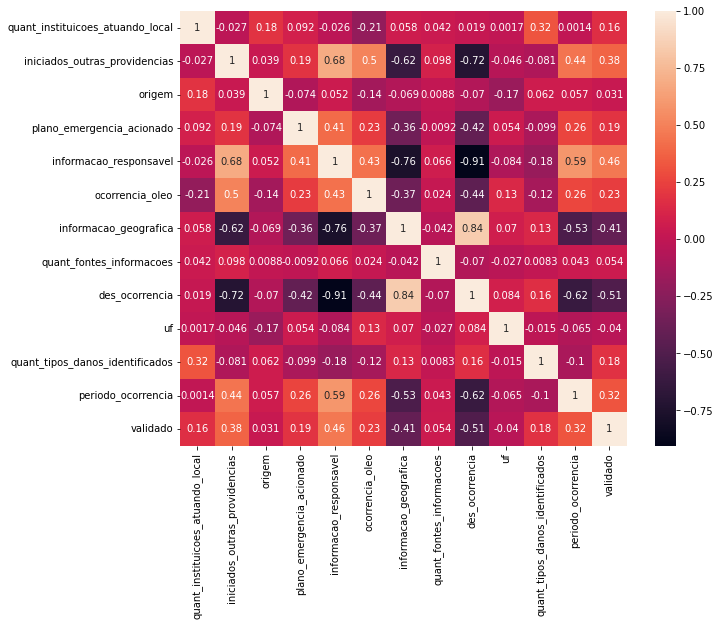

In [35]:
corr = notifications.corr()

# Showing results
plt.figure(figsize=(10, 8))

sns.heatmap(corr, annot=True)

plt.show()

### Data processing for ML models

Building the inputs for the classifier:

In [36]:
X = notifications.drop(["validado"], axis=1).to_numpy()
y = notifications["validado"].to_numpy()

N, p = X.shape

print("Number of samples:", N)
print("Number of parameters:", p)

Number of samples: 11616
Number of parameters: 12


Obs.: It was not considered necessary to normalize or standardize the data.

Separating data between training and testing:

 - The decision to split the data before all classifiers is to ensure that all classifiers train on the same data.

In [37]:
# N obtained by the golden rule applied to each of the models will allow us to use 30% of the data for testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

N_train, N_test = X_train.shape[0], X_test.shape[0]

print("Number of samples in training:", N_train)
print("Number of samples in the test:", N_test)

Number of samples in training: 8131
Number of samples in the test: 3485


### Decision tree

Getting the VC dimension for decision trees:

In [38]:
summ = sum(2**(len(notifications[col].unique()) - 1)
           for col in notifications)

d_vc = int(np.log(summ + 1) + 1)

print("VC dimension:", d_vc)
print("By the golden rule: N >=", d_vc*10)

VC dimension: 19
By the golden rule: N >= 190


As the training set has size 8131 (being above the 190 necessary examples) the golden rule is satisfied.

Building a decision tree with the training instance:

In [39]:
clf_tree = DecisionTreeClassifier()

clf_tree.fit(X_train, y_train)

DecisionTreeClassifier()

Plotting the tree and computing `𝐸𝑖𝑛` and `𝐸𝑜𝑢𝑡` to analyze for overfitting:

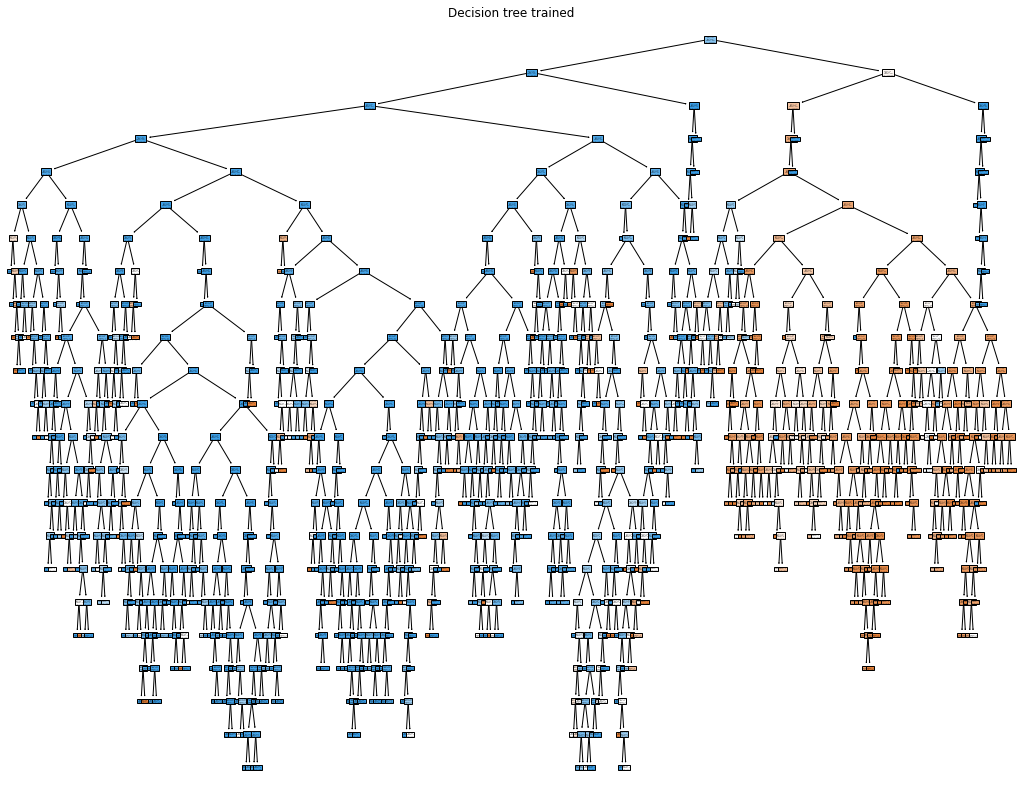

In [40]:
plt.figure(figsize=(18, 14))

plot_tree(clf_tree, filled=True)
plt.title("Decision tree trained")
plt.show()

In [41]:
print("Analyzing the results obtained with DecisionTreeClassifier:")

print()
print(f"Ein = {(1 - clf_tree.score(X_train, y_train))*100:.2f}%")
print(f"Eout = {(1 - clf_tree.score(X_test, y_test))*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(y_test, clf_tree.predict(X_test)),
                   index=['f(x)=0', 'f(x)=1'],
                   columns=['h(x)=0', 'h(x)=1']))

print()
print(classification_report(y_test, clf_tree.predict(X_test)))

Analyzing the results obtained with DecisionTreeClassifier:

Ein = 8.99%
Eout = 12.91%

        h(x)=0  h(x)=1
f(x)=0     874     102
f(x)=1     348    2161

              precision    recall  f1-score   support

           0       0.72      0.90      0.80       976
           1       0.95      0.86      0.91      2509

    accuracy                           0.87      3485
   macro avg       0.84      0.88      0.85      3485
weighted avg       0.89      0.87      0.87      3485



Note: the results obtained allow us to infer that there was no overfitting, as the difference between `Ein` and `Eout` was low (less than 4%).

But, regularizing the value of 𝛼 using the Minimal Cost-Complexity algorithm:

 - It is considered by the golden rule $K = \frac{N}{5}$.

In [42]:
clf = DecisionTreeClassifier()
ccp_alphas = clf.cost_complexity_pruning_path(X_train, y_train).ccp_alphas

param_grid = {'ccp_alpha' : ccp_alphas[ccp_alphas > 0]}

CV_clf_tree = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
CV_clf_tree.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([7.43717613e-08, 1.49983052e-07, 2.47332534e-07, 3.03669389e-07,
       4.30021338e-07, 4.50498544e-07, 5.74164811e-07, 5.85648107e-07,
       6.28281495e-07, 6.63892591e-07, 7.45370319e-07, 7.45370319e-07,
       8.74901136e-07, 9.04309578e-07, 9.76080179e-07, 9.80750419e-07,
       1.02809699e-06, 1.02809699e...
       1.36651225e-04, 1.41910327e-04, 1.46412027e-04, 1.46484817e-04,
       1.47401759e-04, 1.60487478e-04, 1.63827568e-04, 1.98735442e-04,
       2.12726679e-04, 2.25726820e-04, 2.33032635e-04, 2.59503138e-04,
       2.66638221e-04, 3.18615414e-04, 3.31560972e-04, 3.94694236e-04,
       4.29215644e-04, 4.44696323e-04, 4.96554323e-04, 5.71801324e-04,
       1.12769233e-03, 1.83141778e-03, 3.27680289e-03, 5.48903682e-03,
       4.44435710e-02, 7.49935893e-02, 1.05903620e-01])})

Regularization results:

In [43]:
results = pd.DataFrame(CV_clf_tree.cv_results_)

results = results.sort_values(by=["rank_test_score"])

results = results.set_index(results["params"].apply(lambda x: x['ccp_alpha']))

results[["mean_test_score", "std_test_score"]]

,mean_test_score,std_test_score
params,,
0.000332,0.896199,0.005615
0.000395,0.896199,0.005615
0.001128,0.896199,0.005574
0.000319,0.896199,0.005615
0.001831,0.896199,0.005574
...,...,...
0.000014,0.870003,0.007931
0.000010,0.870003,0.008513
0.000020,0.869757,0.008731


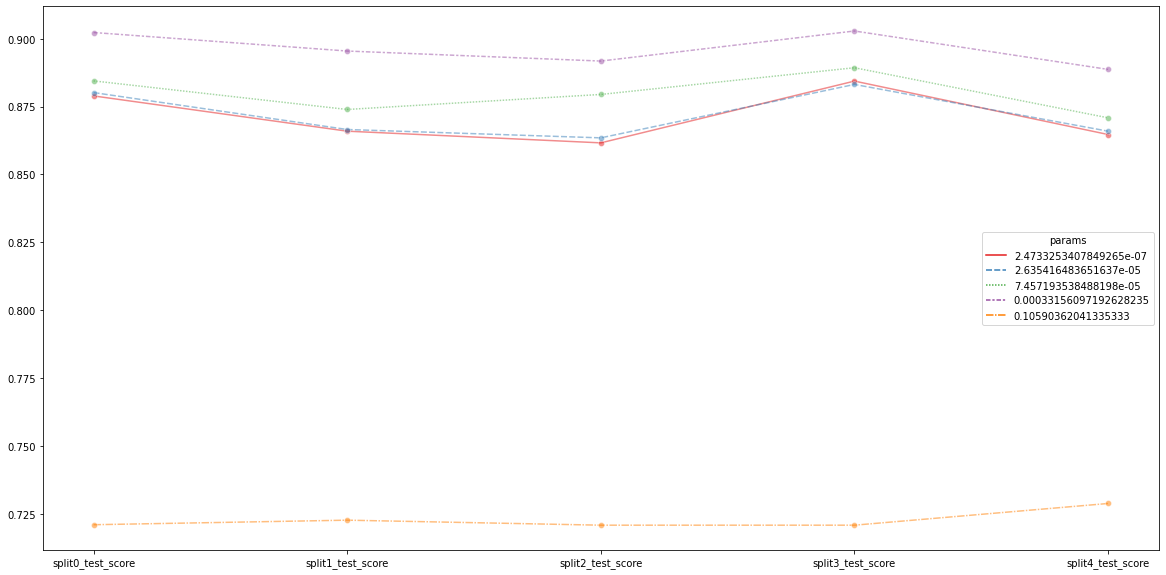

In [44]:
plt.figure(figsize=(20, 10))

sns.lineplot(data=results.transpose().iloc[6:11, np.linspace(0, results.shape[0]-1, 5, dtype='int64')],
             palette="Set1", marker="o", alpha=0.5)

plt.show()

Plotting the tree and computing the quality metrics of the best built tree:

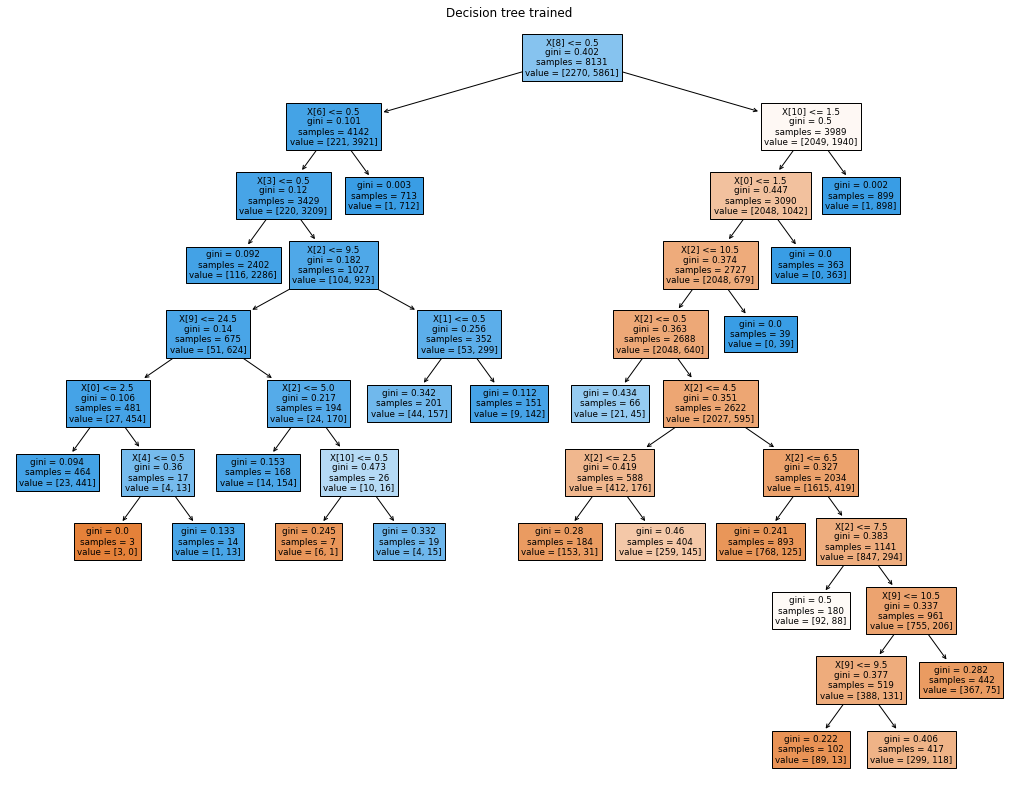

In [45]:
plt.figure(figsize=(18, 14))

plot_tree(CV_clf_tree.best_estimator_, filled=True)
plt.title("Decision tree trained")
plt.show()

In [46]:
print("Getting the relevants features:")

print()

for i, v in enumerate(CV_clf_tree.best_estimator_.feature_importances_):
    if v:
        print(f"X[{i}] = {notifications.columns[i]} ({v})")

Getting the relevants features:

X[0] = quant_instituicoes_atuando_local (0.181679594917035)
X[1] = iniciados_outras_providencias (0.0021933251110534424)
X[2] = origem (0.06606042952718624)
X[3] = plano_emergencia_acionado (0.002023515124675824)
X[4] = informacao_responsavel (0.0021352893032148498)
X[6] = informacao_geografica (0.0023301551768424703)
X[8] = des_ocorrencia (0.43156925175302807)
X[9] = uf (0.00425719999622683)
X[10] = quant_tipos_danos_identificados (0.30775123909073726)


In [47]:
print("Analyzing the results obtained with DecisionTreeClassifier:")

print()
print(f"Best parameters: {CV_clf_tree.best_estimator_}")

print()
print(f"Ein = {(1 - CV_clf_tree.score(X_train, y_train))*100:.2f}%")
print(f"Eout = {(1 - CV_clf_tree.score(X_test, y_test))*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(y_test, CV_clf_tree.predict(X_test)),
                   index=['f(x)=0', 'f(x)=+1'],
                   columns=['h(x)=0', 'h(x)=+1']))

print()
print(classification_report(y_test, CV_clf_tree.predict(X_test)))

Analyzing the results obtained with DecisionTreeClassifier:

Best parameters: DecisionTreeClassifier(ccp_alpha=0.00031861541386152964)

Ein = 10.21%
Eout = 10.65%

         h(x)=0  h(x)=+1
f(x)=0      889       87
f(x)=+1     284     2225

              precision    recall  f1-score   support

           0       0.76      0.91      0.83       976
           1       0.96      0.89      0.92      2509

    accuracy                           0.89      3485
   macro avg       0.86      0.90      0.88      3485
weighted avg       0.91      0.89      0.90      3485



We verified that even without apparent overfitting, the regularization process allowed to increase the accuracy in the test when it got a little worse in training. Thus, the generalization becomes even greater when the errors in training and testing are very close.

### SVM

Getting the VC dimension for Support Vector Machine assuming the data is linearly separable:

$D_{vc} = d+1$

We verify that the size of the training set allows generalization.

In [48]:
d_vc = X.shape[1] + 1

print("VC dimension:", d_vc)
print("By the golden rule: N >=", d_vc*10)

VC dimension: 13
By the golden rule: N >= 130


Using the default kernel of sklearn `kernel='rbf'` we know that: finding VC dimension is non-trivial and RBF have infinite VC dimension but still work well in practice.

Building a SVM with the training instance:

In [49]:
clf_svm = SVC()

clf_svm.fit(X_train,y_train)

SVC()

In [50]:
print("Analyzing the results obtained with SupportVectorMachine:")

print()
print(f"E_in = {(1 - clf_svm.score(X_train, y_train))*100:.2f}%")
print(f"E_out = {(1 - clf_svm.score(X_test, y_test))*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(y_test, clf_svm.predict(X_test)),
                   index=['f(x)=0', 'f(x)=+1'],
                   columns=['h(x)=0', 'h(x)=+1']))

print()
print(classification_report(y_test, clf_svm.predict(X_test)))

Analyzing the results obtained with SupportVectorMachine:

E_in = 14.65%
E_out = 15.67%

         h(x)=0  h(x)=+1
f(x)=0      896       80
f(x)=+1     466     2043

              precision    recall  f1-score   support

           0       0.66      0.92      0.77       976
           1       0.96      0.81      0.88      2509

    accuracy                           0.84      3485
   macro avg       0.81      0.87      0.82      3485
weighted avg       0.88      0.84      0.85      3485



The results obtained allow us to infer that there was no overfitting, as the difference between `Ein` and `Eout` was low.

To try to get a better classifier we will use cross-validating and testing various parameterization combinations:

 - It is considered by the golden rule $K = \frac{N}{5}$.

In [51]:
# Using kernel RBF (radial base function) Gaussian for non-linear problems

param_grid = {'C' : [1, 2, 5, 10],  # regularization parameter (the penalty is a squared l2 penalty)
              'gamma' : [0.1, 0.01, 1, 5]}  # regularization hyperparameter

CV_clf_svm = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=param_grid, cv=5)

CV_clf_svm.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 2, 5, 10], 'gamma': [0.1, 0.01, 1, 5]})

In [52]:
print("Analyzing the results obtained with SupportVectorMachine:")

print()
print(f"Best parameters: {CV_clf_svm.best_estimator_}")

print()
print(f"E_in = {(1 - CV_clf_svm.score(X_train, y_train))*100:.2f}%")
print(f"E_out = {(1 - CV_clf_svm.score(X_test, y_test))*100:.2f}%")
print(f"E[E_out_] <= {(len(CV_clf_svm.best_estimator_.support_vectors_) / len(X_train))*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(y_test, CV_clf_svm.predict(X_test)),
                   index=['f(x)=0', 'f(x)=+1'],
                   columns=['h(x)=0', 'h(x)=+1']))

print()
print(classification_report(y_test, CV_clf_svm.predict(X_test)))

Analyzing the results obtained with SupportVectorMachine:

Best parameters: SVC(C=5, gamma=0.1)

E_in = 10.06%
E_out = 10.82%
E[E_out_] <= 29.96%

         h(x)=0  h(x)=+1
f(x)=0      891       85
f(x)=+1     292     2217

              precision    recall  f1-score   support

           0       0.75      0.91      0.83       976
           1       0.96      0.88      0.92      2509

    accuracy                           0.89      3485
   macro avg       0.86      0.90      0.87      3485
weighted avg       0.90      0.89      0.89      3485



Better results were obtained after the regularization of the C and gamma parameters. The results obtained allow us to infer that there was no overfitting, as the difference between `Ein` and `Eout` was low and as the `Eout` is smaller than the expected Eout, then generalization is guaranteed.

### Neural networks

Getting the maximum number of neurons for a single-layer network

$$n \leq \left \lfloor {\frac{{\lvert}DS{\rvert}-10}{10(d+2)}}  \right \rfloor$$

It is known that the VC dimension for a network with a single layer is: $D_{vc} = [(d+1)n + (n+1)]$

In [53]:
DS = len(X_train)
d = X_train.shape[1]

n = int((DS-10) / (10*(d+2)))
d_vc = (d+1)*n + (n+1)

print(f"Number of neurons in the hidden layer: {n}")
print("VC dimension assuming use of all possible neurons:", d_vc)

Number of neurons in the hidden layer: 58
VC dimension assuming use of all possible neurons: 813


By the golden rule let's get the minimun value for examples:

$$N >= 10d_{VC}$$

As the training set has size 8131 (being above the 8130 necessary examples) the golden rule is satisfied.

Auxiliary functions for building models (neural network with a single hidden layer):

In [54]:
def create_model(n, d):
    model = Sequential()  # instantiating the architecture of the neural network

    # Network configured based on information from the VC dimension and the golden rule
    model.add(Dense(n, input_dim=d, kernel_initializer='normal', activation='tanh'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

    #  Instantiation and configuration of optimizers
    adam = optimizers.Adam(learning_rate=0.01)  # Adaptive Moment Estimation

    # Compiles the model. The chosen optimizer was Adam
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

Building the model with the data and information obtained above:

In [55]:
clf_neural = create_model(n, d)

print(clf_neural.summary())

2023-02-03 14:30:54.118081: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-03 14:30:54.118208: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (reiluisinho): /proc/driver/nvidia/version does not exist
2023-02-03 14:30:54.142358: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 58)                754       
                                                                 
 dense_1 (Dense)             (None, 1)                 59        
                                                                 
Total params: 813
Trainable params: 813
Non-trainable params: 0
_________________________________________________________________
None


Training a neural network:

In [56]:
history = clf_neural.fit(X_train, y_train, epochs=500, batch_size=2048)

Epoch 1/500
4/4 [==============================] - 1s 16ms/step - loss: 0.6189 - accuracy: 0.6260
Epoch 2/500
4/4 [==============================] - 0s 8ms/step - loss: 0.5754 - accuracy: 0.7208
Epoch 3/500
4/4 [==============================] - 0s 9ms/step - loss: 0.5398 - accuracy: 0.7209
Epoch 4/500
4/4 [==============================] - 0s 9ms/step - loss: 0.4859 - accuracy: 0.7209
Epoch 5/500
4/4 [==============================] - 0s 8ms/step - loss: 0.4377 - accuracy: 0.7858
Epoch 6/500
4/4 [==============================] - 0s 9ms/step - loss: 0.4125 - accuracy: 0.8556
Epoch 7/500
4/4 [==============================] - 0s 8ms/step - loss: 0.3996 - accuracy: 0.8723
Epoch 8/500
4/4 [==============================] - 0s 9ms/step - loss: 0.3893 - accuracy: 0.8862
Epoch 9/500
4/4 [==============================] - 0s 8ms/step - loss: 0.3811 - accuracy: 0.8786
Epoch 10/500
4/4 [==============================] - 0s 10ms/step - loss: 0.3723 - accuracy: 0.8885
Epoch 11/500
4/4 [=========

4/4 [==============================] - 0s 8ms/step - loss: 0.2888 - accuracy: 0.8912
Epoch 85/500
4/4 [==============================] - 0s 6ms/step - loss: 0.2878 - accuracy: 0.8907
Epoch 86/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2959 - accuracy: 0.8912
Epoch 87/500
4/4 [==============================] - 0s 5ms/step - loss: 0.2895 - accuracy: 0.8909
Epoch 88/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2888 - accuracy: 0.8912
Epoch 89/500
4/4 [==============================] - 0s 8ms/step - loss: 0.2880 - accuracy: 0.8908
Epoch 90/500
4/4 [==============================] - 0s 8ms/step - loss: 0.2868 - accuracy: 0.8904
Epoch 91/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2866 - accuracy: 0.8905
Epoch 92/500
4/4 [==============================] - 0s 6ms/step - loss: 0.2855 - accuracy: 0.8914
Epoch 93/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2860 - accuracy: 0.8914
Epoch 94/500
4/4 [===============

Epoch 167/500
4/4 [==============================] - 0s 8ms/step - loss: 0.2788 - accuracy: 0.8921
Epoch 168/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2784 - accuracy: 0.8916
Epoch 169/500
4/4 [==============================] - 0s 6ms/step - loss: 0.2787 - accuracy: 0.8920
Epoch 170/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2799 - accuracy: 0.8920
Epoch 171/500
4/4 [==============================] - 0s 8ms/step - loss: 0.2779 - accuracy: 0.8919
Epoch 172/500
4/4 [==============================] - 0s 9ms/step - loss: 0.2774 - accuracy: 0.8921
Epoch 173/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2773 - accuracy: 0.8921
Epoch 174/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2775 - accuracy: 0.8920
Epoch 175/500
4/4 [==============================] - 0s 8ms/step - loss: 0.2773 - accuracy: 0.8921
Epoch 176/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2772 - accuracy: 0.8921
Epoch 177/

4/4 [==============================] - 0s 6ms/step - loss: 0.2739 - accuracy: 0.8920
Epoch 250/500
4/4 [==============================] - 0s 6ms/step - loss: 0.2744 - accuracy: 0.8921
Epoch 251/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2727 - accuracy: 0.8920
Epoch 252/500
4/4 [==============================] - 0s 8ms/step - loss: 0.2721 - accuracy: 0.8921
Epoch 253/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2753 - accuracy: 0.8921
Epoch 254/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2730 - accuracy: 0.8920
Epoch 255/500
4/4 [==============================] - 0s 6ms/step - loss: 0.2726 - accuracy: 0.8921
Epoch 256/500
4/4 [==============================] - 0s 6ms/step - loss: 0.2715 - accuracy: 0.8920
Epoch 257/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2716 - accuracy: 0.8920
Epoch 258/500
4/4 [==============================] - 0s 6ms/step - loss: 0.2713 - accuracy: 0.8920
Epoch 259/500
4/4 [=====

4/4 [==============================] - 0s 7ms/step - loss: 0.2686 - accuracy: 0.8923
Epoch 332/500
4/4 [==============================] - 0s 8ms/step - loss: 0.2714 - accuracy: 0.8918
Epoch 333/500
4/4 [==============================] - 0s 5ms/step - loss: 0.2679 - accuracy: 0.8921
Epoch 334/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2683 - accuracy: 0.8921
Epoch 335/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2678 - accuracy: 0.8921
Epoch 336/500
4/4 [==============================] - 0s 8ms/step - loss: 0.2675 - accuracy: 0.8921
Epoch 337/500
4/4 [==============================] - 0s 8ms/step - loss: 0.2667 - accuracy: 0.8921
Epoch 338/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2687 - accuracy: 0.8921
Epoch 339/500
4/4 [==============================] - 0s 6ms/step - loss: 0.2700 - accuracy: 0.8923
Epoch 340/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2677 - accuracy: 0.8920
Epoch 341/500
4/4 [=====

4/4 [==============================] - 0s 6ms/step - loss: 0.2646 - accuracy: 0.8930
Epoch 414/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2646 - accuracy: 0.8935
Epoch 415/500
4/4 [==============================] - 0s 8ms/step - loss: 0.2642 - accuracy: 0.8928
Epoch 416/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2637 - accuracy: 0.8931
Epoch 417/500
4/4 [==============================] - 0s 8ms/step - loss: 0.2640 - accuracy: 0.8931
Epoch 418/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2636 - accuracy: 0.8929
Epoch 419/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2644 - accuracy: 0.8934
Epoch 420/500
4/4 [==============================] - 0s 8ms/step - loss: 0.2650 - accuracy: 0.8931
Epoch 421/500
4/4 [==============================] - 0s 8ms/step - loss: 0.2637 - accuracy: 0.8931
Epoch 422/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2634 - accuracy: 0.8932
Epoch 423/500
4/4 [=====

4/4 [==============================] - 0s 6ms/step - loss: 0.2613 - accuracy: 0.8939
Epoch 496/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2609 - accuracy: 0.8937
Epoch 497/500
4/4 [==============================] - 0s 5ms/step - loss: 0.2605 - accuracy: 0.8937
Epoch 498/500
4/4 [==============================] - 0s 6ms/step - loss: 0.2604 - accuracy: 0.8942
Epoch 499/500
4/4 [==============================] - 0s 5ms/step - loss: 0.2604 - accuracy: 0.8939
Epoch 500/500
4/4 [==============================] - 0s 8ms/step - loss: 0.2602 - accuracy: 0.8939


Analyzing the data obtained:

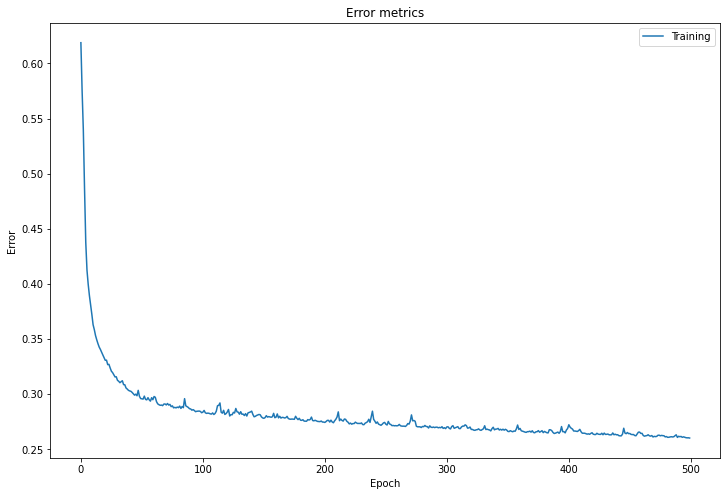

In [57]:
plt.figure(figsize=(12, 8))

plt.plot(history.history['loss'])

plt.title('Error metrics')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['Training'])

plt.show()

In [58]:
pred_train = np.round(clf_neural.predict(X_train, verbose=0))
pred_test = np.round(clf_neural.predict(X_test, verbose=0))

# Printing the results

print("Analyzing the results obtained with NeuralNetwork:")

print()
print(f"E_in = {(1 - accuracy_score(y_train, pred_train))*100:.2f}%")
print(f"E_out = {(1 - accuracy_score(y_test, pred_test))*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(y_test, pred_test),
                   index=['f(x)=0', 'f(x)=+1'],
                   columns=['h(x)=0', 'h(x)=+1']))
print(f'\n{classification_report(y_test, pred_test)}')

Analyzing the results obtained with NeuralNetwork:

E_in = 10.61%
E_out = 11.33%

         h(x)=0  h(x)=+1
f(x)=0      888       88
f(x)=+1     307     2202

              precision    recall  f1-score   support

           0       0.74      0.91      0.82       976
           1       0.96      0.88      0.92      2509

    accuracy                           0.89      3485
   macro avg       0.85      0.89      0.87      3485
weighted avg       0.90      0.89      0.89      3485



During the construction of the ML model, it was tested using the batch_size as the size of the training set (using all the data) and it was verified that when decreasing this size the result improves by less than 1%. In this way, the second highest power of 2 below the size of the training set ($2^{11}$) was chosen for the argument.

This large value for the batch_size allowed us to considerably increase the number of epochs without compromising the efficiency of the algorithm (we used `epochs=500`).

The results obtained allow us to infer that there was no overfitting, as the difference between `Ein` and `Eout`. In this way, a more accurate analysis of the evolution of the model over time is not necessary.

### Conclusion

During the elaboration of the project, we obtained the following classifiers:

In [59]:
clf_tree = DecisionTreeClassifier(ccp_alpha=CV_clf_tree.best_params_['ccp_alpha'])

clf_tree

DecisionTreeClassifier(ccp_alpha=0.00031861541386152964)

In [60]:
clf_svm = SVC(C=CV_clf_svm.best_params_['C'], gamma=CV_clf_svm.best_params_['gamma'])

clf_svm

SVC(C=5, gamma=0.1)

In [61]:
clf_neural = create_model(n, d)

clf_neural.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 58)                754       
                                                                 
 dense_3 (Dense)             (None, 1)                 59        
                                                                 
Total params: 813
Trainable params: 813
Non-trainable params: 0
_________________________________________________________________


Choosing the best model, trained in the previous phases, for the dataset
using the train instance through a validation strategy for choosing
models:

In [62]:
# Separating training data into training and validation

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

N_train, N_val = X_train.shape[0], X_val.shape[0]

print("Number of samples in training:", N_train)
print("Number of samples in validation:", N_val)

Number of samples in training: 6504
Number of samples in validation: 1627


Training the models and getting the one with the best value for Eval:

In [63]:
clf_tree.fit(X_train, y_train)
eval_tree = 1 - clf_tree.score(X_val, y_val)

clf_svm.fit(X_train, y_train)
eval_svm = 1 - clf_svm.score(X_val, y_val)

clf_neural.fit(X_train, y_train, epochs=500, batch_size=2048, verbose=0)
eval_neural = 1 - accuracy_score(y_val, np.round(clf_neural.predict(X_val, verbose=0)))

# Printing the results

print(f"Eval (decision tree classifier) = {eval_tree*100:.2f}%")
print(f"Eval (SVM) = {eval_svm*100:.2f}%")
print(f"Eval (neural network) = {eval_neural*100:.2f}%")

Eval (decision tree classifier) = 9.71%
Eval (SVM) = 10.02%
Eval (neural network) = 10.14%


Best model was the DecisionTreeClassifier:

In [64]:
print("Analyzing the results obtained with the best model (DecisionTreeClassifier):")

print()
print(f"Ein = {(1 - clf_tree.score(X_train, y_train))*100:.2f}%")
print(f"Eout = {(1 - clf_tree.score(X_test, y_test))*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(y_test, clf_tree.predict(X_test)),
                   index=['f(x)=0', 'f(x)=+1'],
                   columns=['h(x)=0', 'h(x)=+1']))

print()
print(classification_report(y_test, clf_tree.predict(X_test)))

Analyzing the results obtained with the best model (DecisionTreeClassifier):

Ein = 10.29%
Eout = 10.67%

         h(x)=0  h(x)=+1
f(x)=0      862      114
f(x)=+1     258     2251

              precision    recall  f1-score   support

           0       0.77      0.88      0.82       976
           1       0.95      0.90      0.92      2509

    accuracy                           0.89      3485
   macro avg       0.86      0.89      0.87      3485
weighted avg       0.90      0.89      0.90      3485



### Discussion

For the problem in question, a false positive means a misuse of public resources. However, a false negative is disastrous because it is a real accident that was ignored, implying forest fires or oil spills spreading for example.

This is a point of improvement in the model as noted below:

In [65]:
confusion = confusion_matrix(y_test, clf_tree.predict(X_test))

print("Analyzing the results obtained with the best model (DecisionTreeClassifier):")

print()
print(f"False positive = {confusion[0][1]}")
print(f"False negative = {confusion[1][0]}")

Analyzing the results obtained with the best model (DecisionTreeClassifier):

False positive = 114
False negative = 258
